# Steps:
1. Load data
2. Select relevant candidates/rows
3. Visualize, clean and convert date columns to datetime
    * cdate [DONE]
    * belafspraak [DONE]
    * geboortedatum [DONE]
4. Visualize and clean categorical variables
    * recruitercode [DONE]
    * utm_source -> clean and merge with source [DONE]
    * utm_medium -> clean and merge with medium [DONE]
    * Clean utm_campaign -> clean and merge with campagneNaam -> Split of location from localized campaigns [DONE]
    * clean utm_adgroup -> clean and merge with adgroup -> Split of location from localized ads [DONE]
    * referrer -> clean [DONE]
    * source -> [REMOVED]
    * medium -> [REMOVED]
    * campagneNaam -> [REMOVED]
    * Adgroup -> [REMOVED]
    * conversiepunt -> [DONE]
    * pagina -> clean and create parent_page [DONE]
    * UitkomstTelefonischContact -> [REMOVED] is alleen of het intake is als resultaat UitkostTelefonischDeal
    * UitkomstTelefonischeDeal -> [DONE]
    * postcode -> convert to location -> split in cities, provinces, randstad vs non-randstad [DONE]
    * leeftijd -> clean and add leeftijd_cat [DONE]
    * Ben je in bezit van rijbewijs -> Clean [DONE] maar alleen 1 iemand zonder rijbewijs waarom is dit er nog?
    * beschikking tot eigen vervoer? -> [DONE]
    * Score 1 -> [DONE] wat zijn dit voor vragen en antwoorden? Ik wil hier graag een voorbeeld van zien en is dit over tijd veranderd?
    * Score 2 -> [DONE] wat zijn dit voor vragen en antwoorden? Ik wil hier graag een voorbeeld van zien en is dit over tijd veranderd?
    * Score 3 -> [DONE] wat zijn dit voor vragen en antwoorden? Ik wil hier graag een voorbeeld van zien en is dit over tijd veranderd?
    * Voorkeursbranche -> [DONE]
    * Motivatie  -> [REMOVED] ONBRUIKBAAR WANT OPEN VELD
    * Werksituatie -> [DONE] lijkt iets raars mee te zijn gebeurd
    * Huidig/Laatste functie -> [REMOVED] ONBRUIKBAAR WANT OPEN VELD
    * Hoe lang in dienst/werkloos [DONE]
    * Meest trotste project -> [REMOVED] open vraag onbruikbaar
    * Strevon startsalaris [DONE]
    * Strevon werktijden [DONE]
    * Verloning marge stopper of W&S overname -> Wacht op toelichting
    * Overname bedrag (W&S) -> Wacht op toelichting
    * groupid
    * stage
    * status
    * starter 
    * berekening - Wacht op toelichting
5. 
6. Visualize and clean continous variable
7. Perform correlation analyses on variables
8. Visualize correlation results
9. Create report  

## Questions
1. At utm_source I replaced werkenbijstrevon with strevon because I figured this is probably the same source. Is this correct?
2. At utm_source I replaced the following values with other: '8kvl4ikw535', 'l', 'ecosia', 'duckduckgo', 'linktr',
       'com', 'googleadservices', 'm', 'nl', 'youtube'. Since there were less then 10 cases of these values. Do you agree?
3. Should we remove everybody without priority 1? Because there are some cases wheren people with starter 1 don't have priority 1.
4. Why do utm_medium and medium not align. How was this database created? Are we sure each data represents a unique candidate???

### 1. Load data

In [1]:
import os
file_path = os.path.join(os.curdir,'data','Kopie van BastianLewisData.xlsx')

In [2]:
import pandas as pd
import numpy as np

df_vars = pd.read_excel(file_path,sheet_name='VariableSelection')
df = pd.read_excel(file_path,sheet_name='Result 1')

var_drop = list(df_vars['Name'][df_vars['Status'] == 'Drop'])

df.drop(labels = var_drop,  axis= 1, inplace = True)

### 2. Select relevant candidates/rows

In [3]:
# alleen 'prioriteit' = 1 houden & geen afwijsBasisGegevens (isnull) 
print('unique prioriteit values:',  df['prioriteit'].unique())
print('unique afwijsBasisGegevens values:',  df['afwijsBasisGegevens'].unique())

df = df[df['prioriteit'] == 1]
df = df[pd.isnull(df['afwijsBasisGegevens'])]
df.drop(labels = ['prioriteit','afwijsBasisGegevens'],  axis= 1, inplace = True)

unique prioriteit values: [ 1. nan  3.  2.  4.]
unique afwijsBasisGegevens values: [nan 'postal_code' 'age' 'drivers_license' 'dutch_language_skill']


In [4]:
len(df)

4129

In [5]:
df['starter'].value_counts()

0    3993
1     136
Name: starter, dtype: int64

### 3. Conver datetime variables to datetime

In [6]:
# date_cols = ['cdate', 'belafspraak', 'geboortedatum']
# df[date_cols].info()

In [7]:
# convert date strings to datetime
date_cols = ['cdate', 'belafspraak', 'geboortedatum']
for date_col in date_cols: 
    df[date_col] = pd.to_datetime(df[date_col], utc=True, errors='coerce')
#df[date_cols].info()

### 4. Clean categorical variables

In [8]:
# Cleaning values with low frequency <10
def clean_categorical_variable(df: pd.DataFrame, column_name: str):
    print(f"working on {column_name}")
    print(f"{len(df[df[column_name].isna()])} missings")
    print("recategorizing all values that appear less then 10 times to 'other'")

    value_counts = df[column_name].value_counts()
    values_to_replace = value_counts[value_counts < 10].index
    values_to_keep = value_counts[value_counts >= 10].index
    df[column_name] = df[column_name].apply(lambda x: 'other' if x in values_to_replace else x)
    print(f"replaced the following values with other: {values_to_replace}")
    print(f"Keeping the following values: {values_to_keep}")
    print("_________________________")

import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_distribution(df, column):
    # Count occurrences of each category
    value_counts = df[column].value_counts()

    # Identify categories that occur less than 10 times
    rare_categories = value_counts[value_counts < 10].index

    # Replace rare categories with 'Other'
    # df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)

    # Count occurrences again after grouping rare categories
    value_counts = df[column].value_counts()

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# for column_name in object_columns:
#     clean_categorical_variable(df, column_name)

# object_columns = df.select_dtypes(include='object').columns.tolist()
# other_columns = ['postcode','leeftijd','motivatie',"Huidig/Laatste functie","Hoe lang in dienst/werkloos","Meest trotste project"]
# for col in other_columns:
#     if col in object_columns:
#         object_columns.remove(col)

In [9]:
# for col in df.columns.to_list():
#     print(f"* {col}")

### cleaning and merging utm_source and source

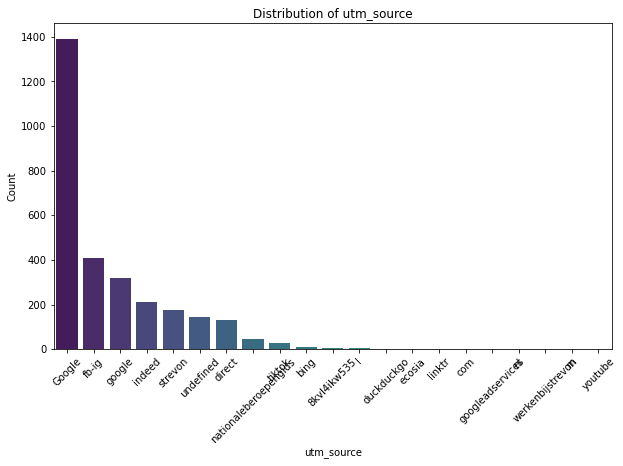

In [10]:
column = "utm_source"
plot_categorical_distribution(df, column)

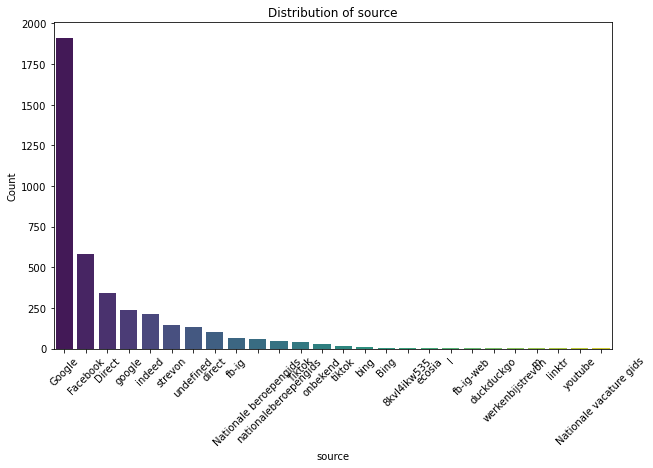

In [11]:
column = "source"
plot_categorical_distribution(df, column)

In [12]:
df['source'] = df['source'].str.lower()
df['source'] = df['source'].replace("nationale beroepengids", "nationaleberoepengids")
df['source'] = df['source'].replace("werkenbijstrevon", "strevon")
df['source'] = df['source'].replace("onbekend", "undefined")
df['source'] = df['source'].fillna(df['utm_source'])
clean_categorical_variable(df, 'source')

df['utm_source'] = df['utm_source'].str.lower()
df["utm_source"].replace('werkenbijstrevon', 'strevon',inplace=True) #Mag dit is dit hetzelfde?
df['source'] = df['source'].replace("direct","strevon")
df['utm_source'] = df['utm_source'].replace("direct","strevon")
df['utm_source'] = df['utm_source'].fillna(df['source'])
clean_categorical_variable(df, 'utm_source')

column_a = 'utm_source'
column_b = 'source'
x = "undefined"
df[column_a] = df.apply(lambda row: row[column_b] if row[column_a] == x else row[column_a], axis=1)

column_a = 'source'
column_b = 'utm_source'
x = "undefined"
df[column_a] = df.apply(lambda row: row[column_b] if row[column_a] == x else row[column_a], axis=1)

column_a = 'source'
column_b = 'utm_source'
x = "facebook"
df[column_a] = df.apply(lambda row: row[column_b] if row[column_a] == x else row[column_a], axis=1)

working on source
173 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['8kvl4ikw535', 'l', 'ecosia', 'fb-ig-web', 'duckduckgo', 'Google',
       'linktr', 'nationale vacature gids', 'm', 'youtube'],
      dtype='object')
Keeping the following values: Index(['google', 'facebook', 'direct', 'indeed', 'undefined', 'strevon',
       'nationaleberoepengids', 'fb-ig', 'tiktok', 'bing'],
      dtype='object')
_________________________
working on utm_source
173 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['8kvl4ikw535', 'other', 'l', 'ecosia', 'duckduckgo', 'linktr', 'nl',
       'm', 'com', 'googleadservices', 'youtube'],
      dtype='object')
Keeping the following values: Index(['google', 'strevon', 'fb-ig', 'facebook', 'indeed', 'undefined',
       'nationaleberoepengids', 'tiktok', 'bing'],
      dtype='object')
______________________

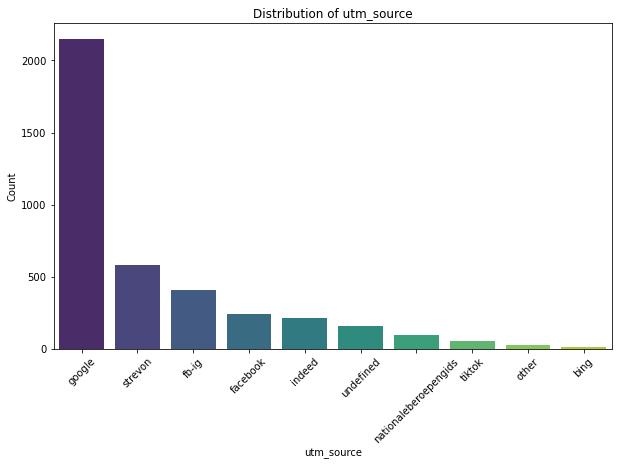

In [13]:
column = "utm_source"
plot_categorical_distribution(df, column)

In [14]:
## Drop source and keep utm_source
df.drop(['source'], axis=1, inplace=True)

### Visualizing, cleaning and merging utm_medium and medium

BEFORE


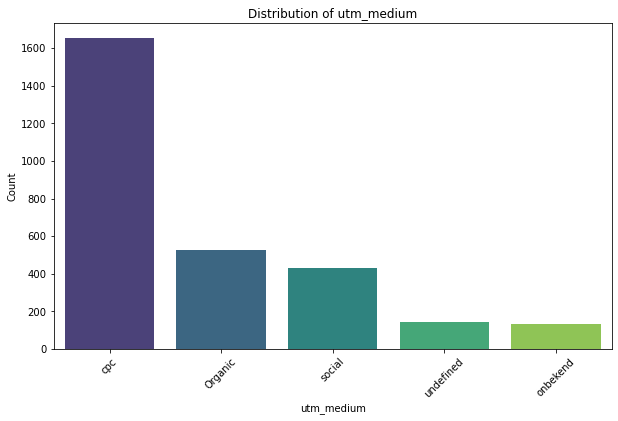

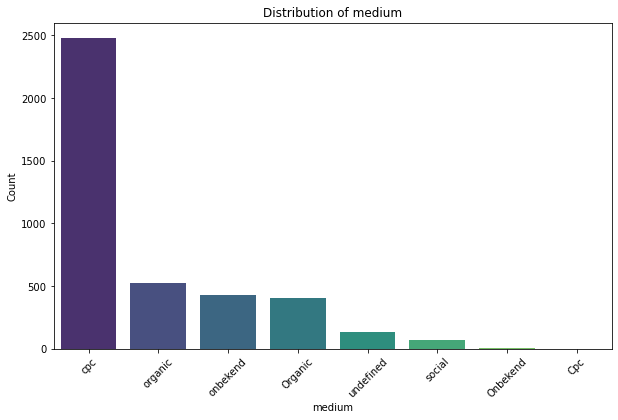

AFTER


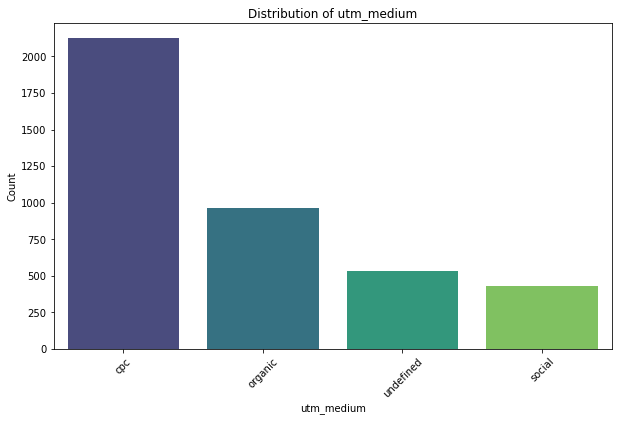

In [15]:
print("BEFORE")
column = "utm_medium"
plot_categorical_distribution(df, column)

column = "medium"
plot_categorical_distribution(df, column)

# Visualizeing, Cleaning and merging utm_medium and medium
df['medium'] = df['medium'].str.lower()
df['medium'] = df['medium'].replace("onbekend", "undefined")

df['utm_medium'] = df['utm_medium'].str.lower()
df['utm_medium'] = df['utm_medium'].replace("onbekend","undefined")
df['utm_medium'] = df['utm_medium'].fillna(df['medium'])

column_a = 'utm_medium'
column_b = 'medium'
x = "undefined"
df[column_a] = df.apply(lambda row: row[column_b] if row[column_a] == x else row[column_a], axis=1)

column_a = 'medium'
column_b = 'utm_medium'
x = "undefined"
df[column_a] = df.apply(lambda row: row[column_b] if row[column_a] == x else row[column_a], axis=1)

df['medium'] = df['medium'].str.lower()
df['medium'] = df['medium'].fillna(df['utm_medium'])
df.drop("medium", axis=1, inplace = True)

print("AFTER")
column = "utm_medium"
plot_categorical_distribution(df, column)

### Visualize, Clean and Merge utm_campaign and campagneNaam

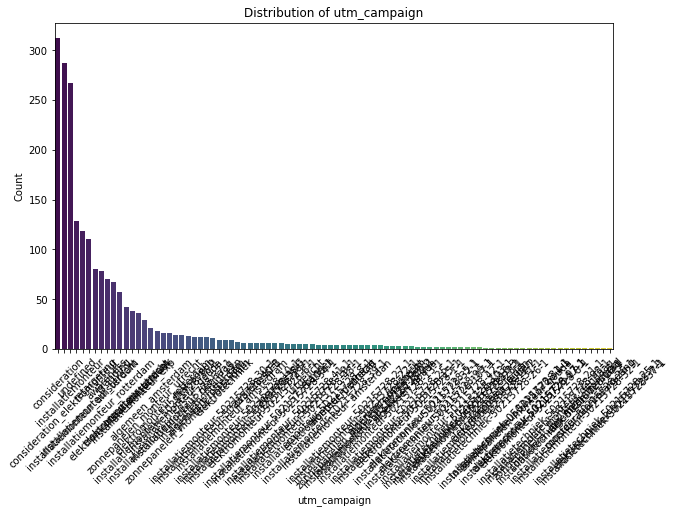

In [16]:
column = "utm_campaign"
plot_categorical_distribution(df, column)

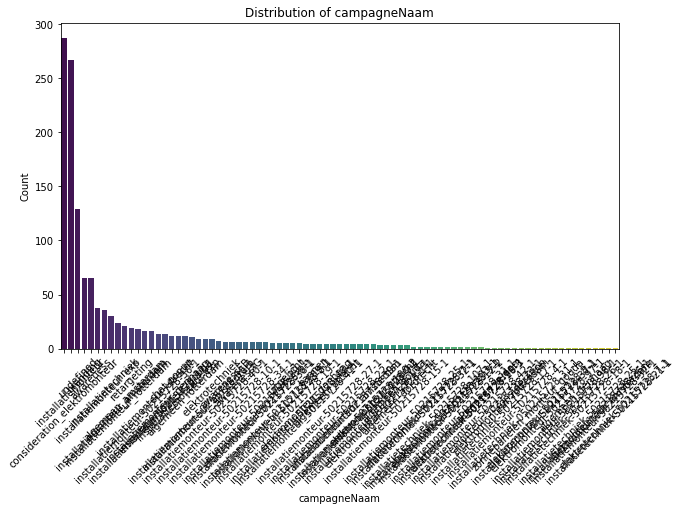

In [17]:
column = "campagneNaam"
plot_categorical_distribution(df, column)

In [18]:
elektrotechniek_values = ['elektrotechniek-50215728-7-1']

installatietechniek_values = ['installatietechniek-50215728-103-1',
 'installatietechniek-50215728-32-1',
 'installatietechniek-50215728-107-1',
 'installatietechniek-50215728-16-3',
 'installatietechniek-50215728-25-1',
 'installatietechniek-50215728-18-1',
 'installatietechniek-50215728-26-1',
 'installatietechniek-50215728-21-1',
 'installatietechniek-50215728-37-1',
 'installatietechniek-50215728-17-1',
 'installatietechniek-050215728-31-1',]

elektromonteur_values = ['elektromonteur-50215728-6-1',
 'elektromonteur-50215728-1-1',
 'elektromonteur-50215728-99-1',
 'elektromonteur-50215728-5-1',
 'elektromonteur-50215728-7-1',
 'elektromonteur-50215728-8-1',
 'elektromonteur-50215728-97-1']



installatiemonteur_values = ['installatiemonteur-50215728-40-1',
 'installatiemonteur-50215728-10-1',
 'installatiemonteur-50215728-38-1',
 'installatiemonteur-50215728-29-1',
 'installatiemonteur-50215728-34-1',
 'installatiemonteur_50215728-41-1',
 'installatiemonteur-50215728-48-1',
 'installatiemonteur-50215728-8-1',
 'installatiemonteur-50215728-19-1',
 'installatiemonteur-50215728-100-2',
 'installatiemonteur-50215728-27-1',
 'installatiemonteur-50215728-22-1',
 'installatiemonteur-50215728-39-1',
 'installatiemonteur-50215728-13-1',
 'installatiemonteur-50215728-9-1',
 'installatiemonteur-50215728-25-1',
 'installatiemonteur-50215728-15-1',
 'installatiemonteur-50215728-23-1',
 'installatiemonteur-50215728-42-1',
 'installatiemonteur-50215728-31-1',
 'installatiemonteur-50215728-12-2',
 'installatiemonteur-50215728-98-1',
 'installatiemonteur-50215728-4-1',
 'installatiemonteur-50215728-26-1',
 'installatiemonteur-50215728-32-1',
 'installatiemonteur-50215728-36-1',
 'installatiemonteur-50215728-37-1',
 'installatiemonteur-50215728-30-1',
 'installatiemonteur-50215728-109-1']

In [19]:

installatiemonteur_values = [val for val in df['utm_campaign'].unique() if "installatiemonteur-" in str(val)]
installatiemonteur_values.remove('installatiemonteur-exp')

In [20]:

installatietechniek_values = [val for val in df['utm_campaign'].unique() if "installatietechniek-" in str(val).lower()]

In [21]:
elektromonteur_values = [val for val in df['utm_campaign'].unique() if "elektromonteur-" in str(val)]
elektromonteur_values += ["elektromonteur50215728-102-1"]

In [22]:
# cleaning utm_campaign
column_name = 'utm_campaign'
df[column_name].replace('installatiemonteur_amstedram', 'installatiemonteur_amsterdam', inplace=True) #Mag dit is dit hetzelfde?
df[column_name].replace('installatiemonteur_amsterdan', 'installatiemonteur_amsterdam', inplace=True) #Mag dit is dit hetzelfde?
for val in installatiemonteur_values:
    df[column_name].replace(val, 'installatiemonteur', inplace=True)
for val in elektromonteur_values:
    df[column_name].replace(val, 'elektromonteur', inplace=True)
for val in installatietechniek_values:
    df[column_name].replace(val, 'installatietechniek', inplace=True)
for val in elektrotechniek_values:
    df[column_name].replace(val, 'elektrotechniek', inplace=True)

In [23]:
# column = "utm_campaign"
# df[column].value_counts()

In [24]:
#create location of utm_campaign variable
df["utm_campaign_location"] = df[column_name].apply(lambda x: str(x).split("_")[-1] if len(str(x).split("_")) > 0 else None)
locations=['amsterdam','utrecht','dordrecht','leiden','gouda','denhaag','utrecht','rotterdam']
df["utm_campaign_location"] = df["utm_campaign_location"].apply(lambda x: x if x in locations else None)

In [25]:
#remove locations from utm_campaigns
df["utm_campaign_no_loc"] = df["utm_campaign"].apply(lambda x: "_".join(str(x).split("_")[:-1]) if str(x).split("_")[-1] in locations else x)

In [26]:
clean_categorical_variable(df, "utm_campaign_no_loc")

working on utm_campaign_no_loc
2046 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['awarenessIG', 'awarenessFB', 'uitgelicht',
       'installatiemonteur_50215728-41-1', 'banner',
       'considera utm_medium=social', 'considerationretargeting'],
      dtype='object')
Keeping the following values: Index(['installatiemonteur', 'consideration', 'consideration_elektromonteur',
       'elektromonteur', 'undefined', 'retargeting', 'awareness', 'branding',
       'installatietechniek', 'zonnepanelen_monteur', 'algemeen',
       'installatiemonteur_exp', 'installatiemonteur-exp', 'chat-popup',
       'elektrotechniek'],
      dtype='object')
_________________________


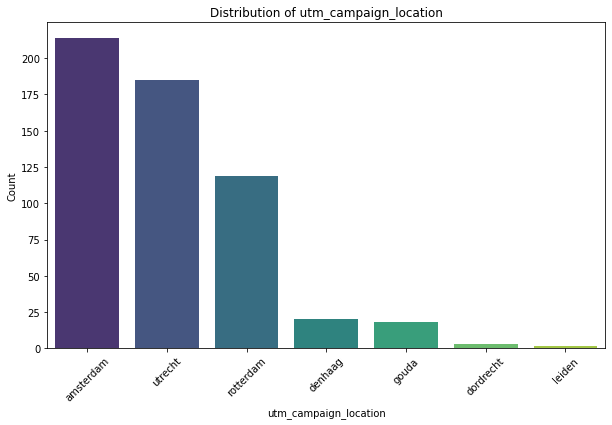

In [27]:
column = "utm_campaign_location"
plot_categorical_distribution(df, column)

In [28]:
df['utm_campaign'].value_counts()

installatiemonteur                  409
consideration                       312
consideration_elektromonteur        287
installatiemonteur_amsterdam        132
undefined                           129
installatiemonteur_utrecht          110
retargeting                          80
installatiemonteur_rotterdam         78
awareness                            70
branding                             67
elektromonteur_amsterdam             57
installatietechniek                  51
elektromonteur_utrecht               42
installatiemonteur_exp               38
zonnepanelen_monteur_utrecht         29
algemeen_amsterdam                   21
elektromonteur                       17
elektromonteur_rotterdam             16
installatiemonteur_gouda             14
installatiemonteur_denhaag           14
zonnepanelen_monteur_rotterdam       13
chat-popup                           12
installatiemonteur-exp               12
algemeen_rotterdam                   12
elektrotechniek                      10


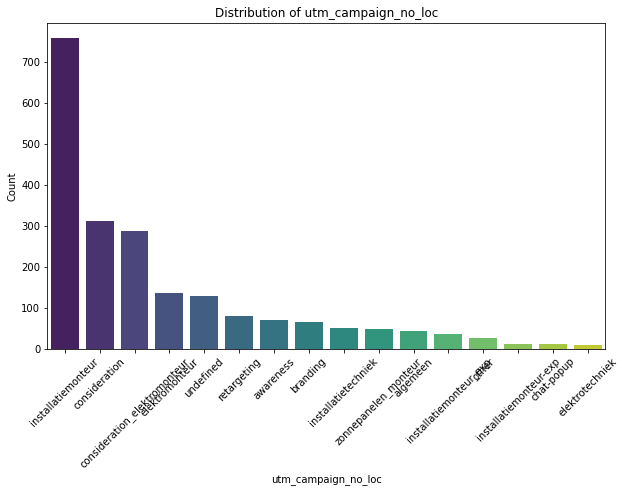

In [29]:
column = "utm_campaign_no_loc"
plot_categorical_distribution(df, column)

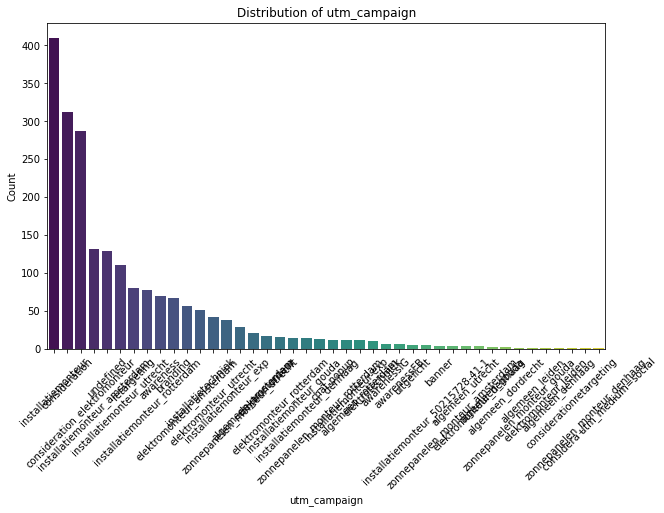

In [30]:
column = "utm_campaign"
plot_categorical_distribution(df, column)

In [31]:
# CampagneNaam is same as utm_campaign so drop
df.drop(['campagneNaam'], axis=1, inplace=True)

## Visualize, clean and merge utm_adgroup and adgroup

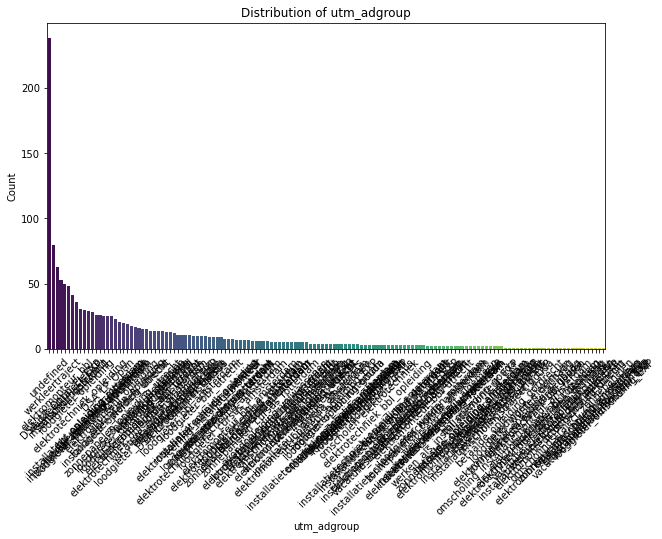

In [32]:
column = "utm_adgroup"
plot_categorical_distribution(df, column)

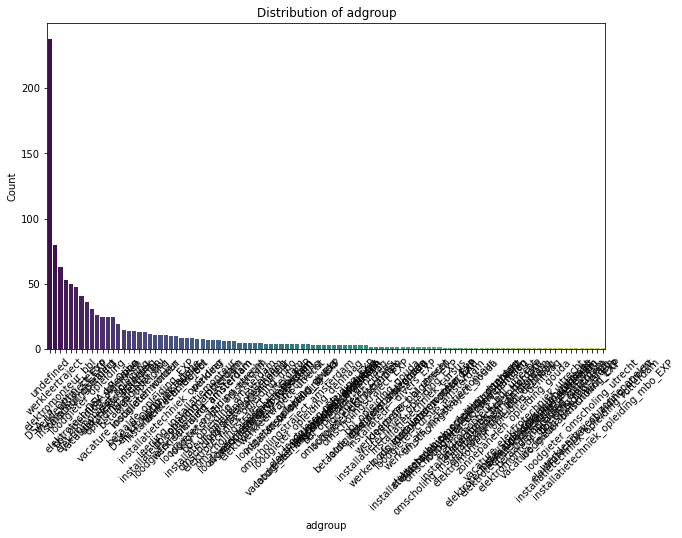

In [33]:
column = "adgroup"
plot_categorical_distribution(df, column)

In [34]:
#create location of utm_adgroup variable
column_name = "utm_adgroup"
df["utm_adgroup_location"] = df[column_name].apply(lambda x: str(x).split("_")[-1] if len(str(x).split("_")) > 0 else None)
locations=['amsterdam','utrecht','dordrecht','leiden','gouda','denhaag','utrecht','rotterdam']
df["utm_adgroup_location"] = df["utm_adgroup_location"].apply(lambda x: x if x in locations else None)

In [35]:
#remove locations from utm_campaigns
df[column_name+"_no_loc"] = df[column_name].apply(lambda x: "_".join(str(x).split("_")[:-1]) if str(x).split("_")[-1] in locations else x)

In [36]:
clean_categorical_variable(df, column_name+"_no_loc")

working on utm_adgroup_no_loc
2596 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['leerling_installatiemonteur', 'elektromonteur_omscholing', 'werkleer',
       'omscholing_installatiemonteur', 'installatietechniek_omscholing',
       'elektrotechniek_opleiding_mbo', 'avondopleiding_volwassenen',
       'installateur_opleiding_EXP', 'loodgieter_bbl_EXP',
       'installatietechniek_cursus', 'elektrotechniek_bbl_opleiding',
       'elektricien_omscholen', 'loodgieter_opleiding_EXP',
       'vacature_leerling_monteur_algemeen', 'omscholen_elektrotechniek',
       'omscholingstraject_EXP', 'installateur__divers_EXP',
       'installatietechniek_opleiding_EXP', 'loodgieter_worden_EXP',
       'werken_als_installatiemonteur', 'werkleertraject_algemeen',
       'werken_als_installatiemonteur_EXP', 'installatietechniek_bbl_EXP',
       'opleidingen_elektricien', 'loodgieter_omscholing_EXP',
       'omscholen_elektr

In [37]:
clean_categorical_variable(df, column_name)

working on utm_adgroup
2596 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['elektrotechniek_omscholing_amsterdam', 'leerling_installatiemonteur',
       'loodgieter_omscholing_utrecht', 'zonnepanelen_cursus_utrecht',
       'werkleertraject_amsterdam', 'bbl_opleiding_rotterdam',
       'loodgieter_cursus_amsterdam', 'elektrotechniek_opleiding_rotterdam',
       'elektromonteur_bbl_amsterdam', 'werkleer',
       ...
       'elektromonteur_omscholing_amsterdam',
       'omscholingstraject_zonnepanelen', 'bbl_opleiding_leiden',
       'zonnepanelen_opleiding_denhaag', 'omscholen_elektricien',
       'betaalde_opleiding_rotterdam', 'vacature_installatiemonteur_EXP',
       'elektromonteur_bbl_denhaag', 'installatietechniek_bbl_EXP',
       'loodgieter_omscholing_EXP'],
      dtype='object', length=102)
Keeping the following values: Index(['undefined', 'werkleertraject', 'elektromonteur_bbl',
       'DSA_LP_Optin

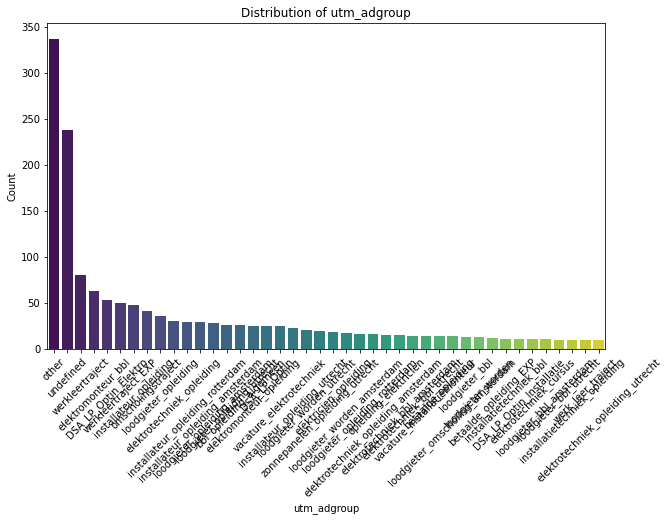

In [38]:
column = "utm_adgroup"
plot_categorical_distribution(df, column)

In [39]:
df['utm_adgroup'].value_counts()

other                                  337
undefined                              238
werkleertraject                         80
elektromonteur_bbl                      63
DSA_LP_Optin_Elektro                    53
werkleertraject_EXP                     50
installateur_opleiding                  48
omscholingstraject                      41
loodgieter_opleiding                    36
elektrotechniek_opleiding               31
installateur_opleiding_rotterdam        30
installateur_opleiding_amsterdam        29
loodgieter_opleiding_amsterdam          28
loodgieter_opleiding_utrecht            26
bbl_opleiding_algemeen                  26
elektromonteur_opleiding                25
DSA_LP_Optin                            25
vacature_elektrotechniek                25
installateur_opleiding_utrecht          23
loodgieter_worden_utrecht               21
zonnepanelen_opleiding_utrecht          20
elektricien_opleiding                   19
loodgieter_worden_amsterdam             18
loodgieter_

In [40]:
df.drop(['adgroup'],axis=1, inplace=True)

### cleaning referrer

In [41]:
column_name =  "referrer"

values = ['strevon.nl', 'www.google.com', 'direct', 'm.facebook.com', np.nan,
       'www.google.nl', 'www.nationaleberoepengids.nl',
       'www.adsensecustomsearchads.com', 'nl.indeed.com',
       'www.ecosia.org', 'duckduckgo.com', 'www.bing.com', 'linktr.ee',
       'www.google.de', 'www.google.com.tr', 'www.google.ae',
       'www.google.it', '8kvl4ikw535.typeform.com', 'www.google.co.jp',
       'l.facebook.com', 'undefined', 'www.youtube.com', 'l.wl.co',
       'com.google.android.googlequicksearchbox',
       'www.googleadservices.com', 'www.google.co.za', 'typeform.com',
       'www.google.fr', 'werkenbijstrevon.nl', 'l.instagram.com',
       'nl.search.yahoo.com', 'lm.facebook.com', 'www.tiktok.com',
       'instagram.com', 'android-app:', 'www.google.ch',
       'strevon-nl.webpkgcache.com', 'web.telegram.org',
       'syndicatedsearch.goog']

google_values = [val for val in values if 'google' in str(val)]
facebook_values = [val for val in values if 'facebook' in str(val)]
strevon_values = [val for val in values if 'strevon' in str(val)] + ["direct"]

df['referrer_clean'] =  df['referrer'].apply(lambda x: 'google' if str(x) in google_values else x)
df['referrer_clean'] =  df['referrer_clean'].apply(lambda x: 'facebook' if str(x) in facebook_values else x)
df['referrer_clean'] =  df['referrer_clean'].apply(lambda x: 'strevon' if str(x) in strevon_values else x)
clean_categorical_variable(df, 'referrer_clean')


df['referrer_clean'] = df['referrer_clean'].str.replace(".com",'')
df['referrer_clean'] =df['referrer_clean'].str.replace("www.",'')
df['referrer_clean'] =df['referrer_clean'].str.replace("nl.",'')
df['referrer_clean'] =df['referrer_clean'].str.replace(".nl",'')

clean_categorical_variable(df, 'referrer')

working on referrer_clean
697 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['duckduckgo.com', 'linktr.ee', 'www.ecosia.org', 'android-app:',
       'nl.search.yahoo.com', 'l.wl.co', 'www.youtube.com', 'web.telegram.org',
       'syndicatedsearch.goog', 'typeform.com', 'l.instagram.com'],
      dtype='object')
Keeping the following values: Index(['google', 'strevon', 'facebook', 'undefined', 'instagram.com',
       'www.tiktok.com', 'nl.indeed.com', '8kvl4ikw535.typeform.com',
       'www.bing.com', 'www.adsensecustomsearchads.com',
       'www.nationaleberoepengids.nl'],
      dtype='object')
_________________________
working on referrer
697 missings
recategorizing all values that appear less then 10 times to 'other'
replaced the following values with other: Index(['duckduckgo.com', 'www.google.de', 'linktr.ee', 'www.ecosia.org',
       'www.youtube.com', 'l.wl.co', 'android-app:', 'nl.search.yahoo.com',
  

<ipython-input-41-d660b69cda99>:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df['referrer_clean'] = df['referrer_clean'].str.replace(".com",'')
<ipython-input-41-d660b69cda99>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df['referrer_clean'] =df['referrer_clean'].str.replace("www.",'')
<ipython-input-41-d660b69cda99>:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df['referrer_clean'] =df['referrer_clean'].str.replace("nl.",'')
<ipython-input-41-d660b69cda99>:31: FutureWarning: The default value of regex will change from True to False in a future version.
  df['referrer_clean'] =df['referrer_clean'].str.replace(".nl",'')


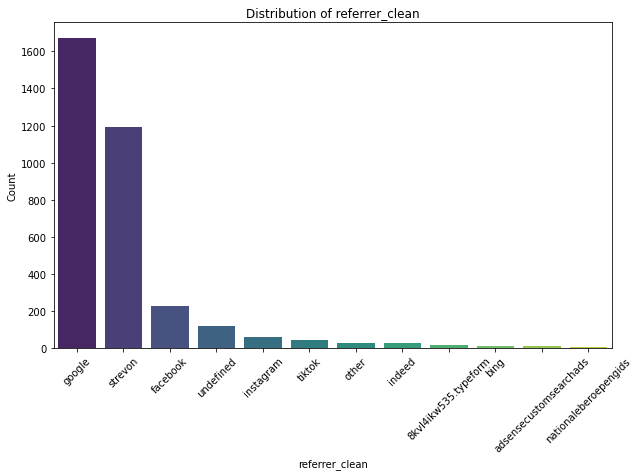

In [42]:
column = "referrer_clean"
plot_categorical_distribution(df, column)

In [43]:
df.drop("referrer",axis=1,inplace=True)

## Conversiepunt Visualize if needed clean

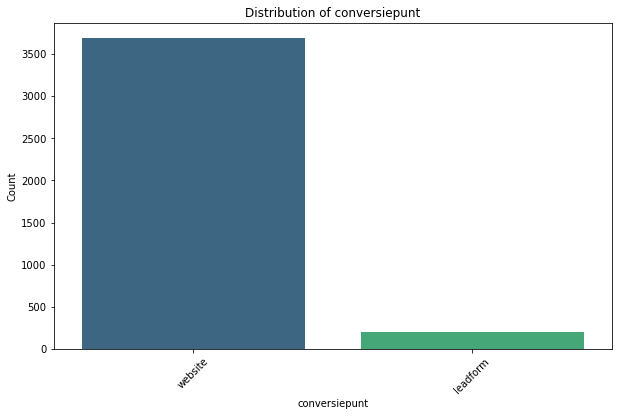

In [44]:
column = 'conversiepunt'
df[column] = df[column].str.lower()
plot_categorical_distribution(df, column)

## Pagina visualize and clean if needed 

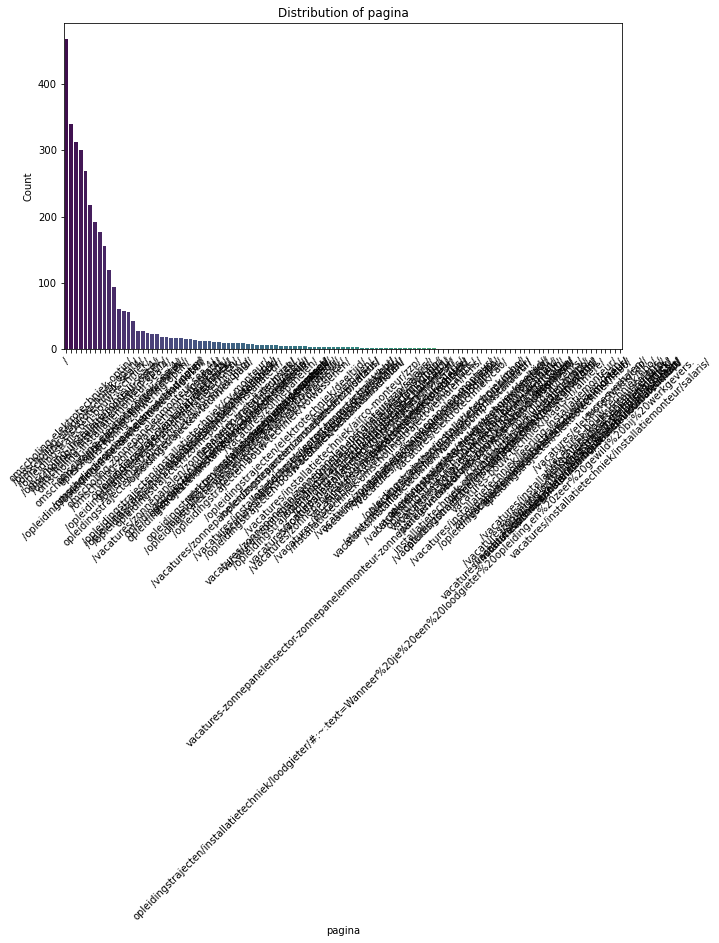

In [45]:
column = 'pagina'
plot_categorical_distribution(df, column)

In [46]:
df[column] = df[column].apply(lambda x: x.strip("/") if type(x)==str else x)

In [47]:
df['parent_page'] = df[column].apply(lambda x: x.split("/")[0] if type(x)==str else x)

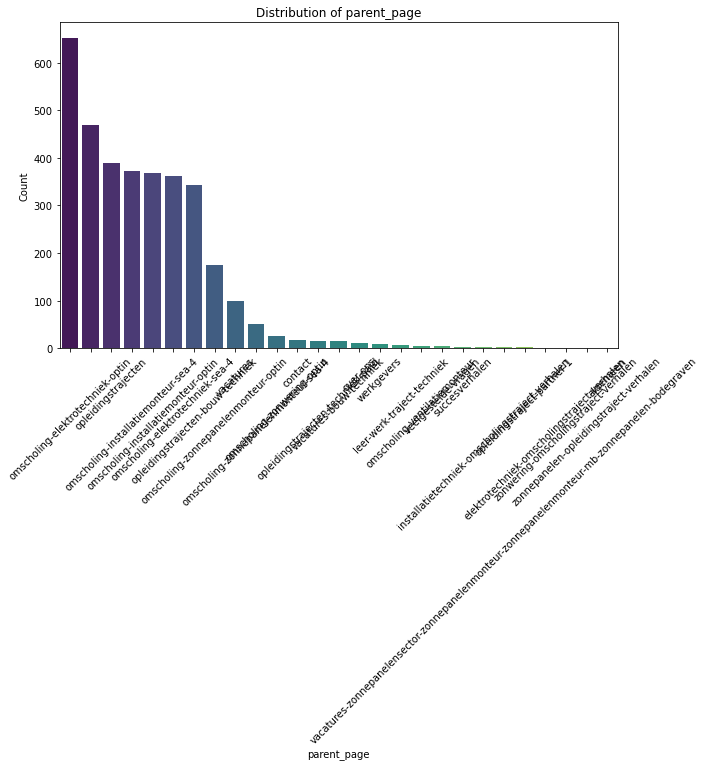

In [48]:
column = 'parent_page'
plot_categorical_distribution(df,column)

## UitkomstTelefonischContact en UitkomstTelefonischDeal Visualize and Clean

In [49]:
df['uitkomstTelefonischDeal'] = df['uitkomstTelefonischDeal'].fillna(df["uitkomstTelefonischContact"])

In [50]:
df[column].value_counts()

omscholing-elektrotechniek-optin                                                                   652
                                                                                                   468
opleidingstrajecten                                                                                389
omscholing-installatiemonteur-sea-4                                                                373
omscholing-installatiemonteur-optin                                                                368
omscholing-elektrotechniek-sea-4                                                                   362
opleidingstrajecten-bouw-techniek                                                                  344
omscholing-zonnepanelenmonteur-optin                                                               176
vacatures                                                                                           99
omscholing-zonnepanelenmonteur-sea-4                                     

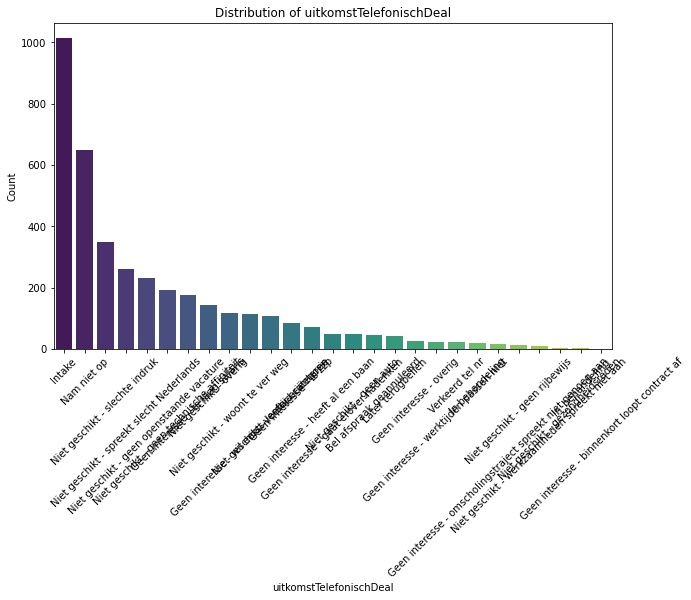

In [51]:
df.drop(column, axis=1, inplace=True)
column = "uitkomstTelefonischDeal"
plot_categorical_distribution(df,column)


## Visualizing and Cleaning leeftijd

In [52]:
df['leeftijd'].unique()

array(['24', '42', '32', '18', '23', '31', '41', '33', '43', '29', '19',
       '20', '36', '21', '26', '27', '28', '34', '37', '49', '25', '45',
       '46', '40', '35', '22', '39', '30', '38', '17', '48', '44', '50',
       '47', '0', '51', '18-30 jaar', '31-49 jaar', nan, '1',
       '50 jaar of ouder'], dtype=object)

In [53]:
import random

In [54]:
df['leeftijd'] = df['leeftijd'].apply(lambda x: str(random.choice(range(18,30))) if x=="18-30 jaar" else x)
df['leeftijd'] = df['leeftijd'].apply(lambda x: str(random.choice(range(31,49))) if x=="31-49 jaar" else x)
df['leeftijd'] = df['leeftijd'].apply(lambda x: str(random.choice(range(31,45))) if x=="31-45 jaar" else x)
df['leeftijd'] = df['leeftijd'].apply(lambda x: str(random.choice(range(50,65))) if x=="50 jaar of ouder" else x)
df['leeftijd'] = df['leeftijd'].apply(float)

In [55]:
df['leeftijd'] = df['leeftijd'].replace(0,np.nan)
df['leeftijd'] = df['leeftijd'].replace(1,np.nan)

In [56]:
def categorize(x):
    if (x>0) & (x<31):
        return "18-30 jaar"
    elif (x>30) & (x<50):
        return "31-49 jaar"
    elif x > 49:
        return "50 jaar of ouder"
    else:
        return np.nan

In [57]:
df['leeftijd_cat'] = df['leeftijd'].apply(lambda x: categorize(x))

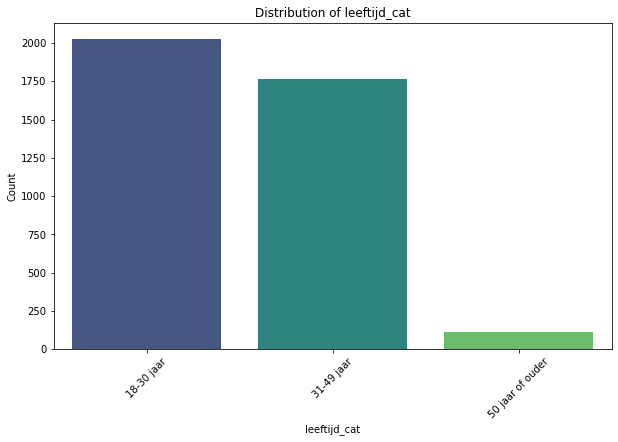

In [58]:
column = 'leeftijd_cat'
plot_categorical_distribution(df,column)

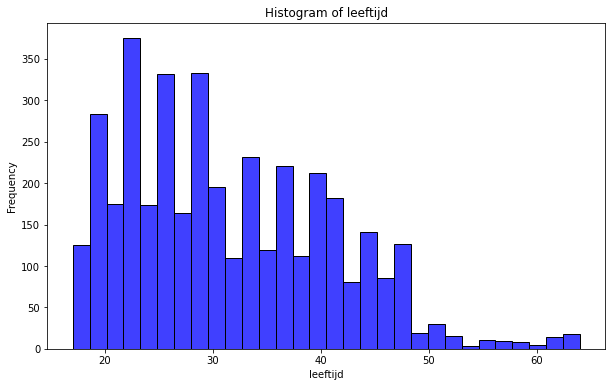

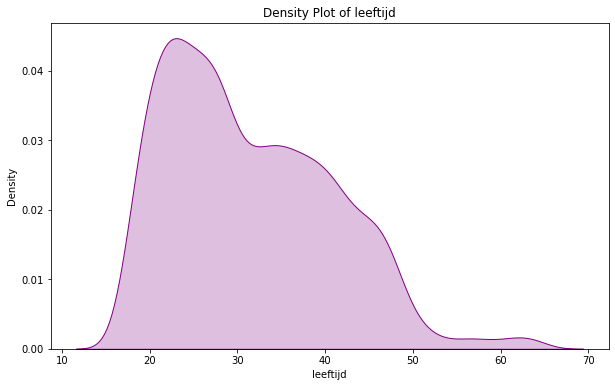

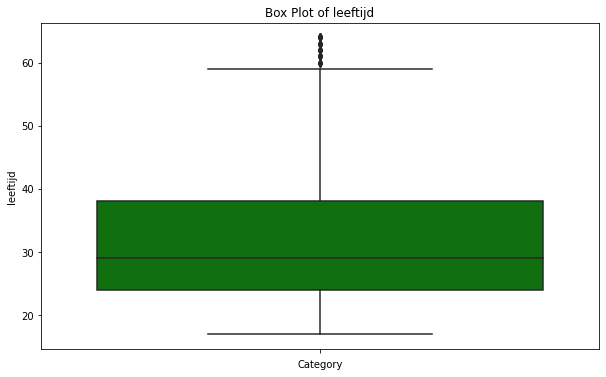

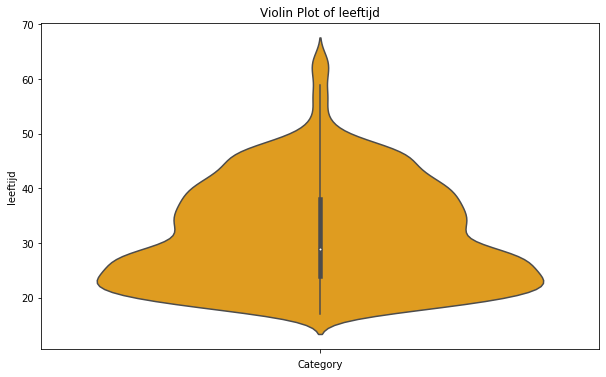

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(df, column, bins=30):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=bins, kde=False, color='blue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

def plot_density(df, column):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[column], shade=True, color='purple')
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

def plot_boxplot(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[column], color='green')
    plt.title(f'Box Plot of {column}')
    plt.xlabel('Category')
    plt.ylabel(column)
    plt.show()

def plot_violinplot(df, column):
    plt.figure(figsize=(10, 6))
    sns.violinplot(y=df[column], color='orange')
    plt.title(f'Violin Plot of {column}')
    plt.xlabel('Category')
    plt.ylabel(column)
    plt.show()

plot_histogram(df, 'leeftijd')
plot_density(df, 'leeftijd')
plot_boxplot(df, 'leeftijd')
plot_violinplot(df, 'leeftijd')


## Ben je in het bezit van een rijbewijs

In [60]:
column ="Ben je in het bezit van rijbewijs?"
df[column] = df[column].str.lower()
df[column] = df[column].str.strip(",")
df[column].value_counts()

ja     1790
nee       1
Name: Ben je in het bezit van rijbewijs?, dtype: int64

## beschikking tot eigen vervoer?

In [61]:
column = "beschikking tot eigen vervoer?"
df[column+"_clean"] = df[column].str.lower()
column = column+"_clean"
df[column] = df[column].apply(lambda x: "nee dit heb ik niet" if str(x) in ["geen auto","geen vervoer"] else x)
df[column] = df[column].apply(lambda x: "ja een eigen auto of motor" if "motor" in str(x) else x)
df[column] = df[column].apply(lambda x: "ja een eigen auto of motor" if "auto" in str(x) else x)
df[column] = df[column].apply(lambda x: "ja een eigen auto of motor" if str(x)=="ja" else x)

df[column].value_counts()

ja een eigen auto of motor    1280
nee dit heb ik niet            401
ja een eigen scooter           109
Name: beschikking tot eigen vervoer?_clean, dtype: int64

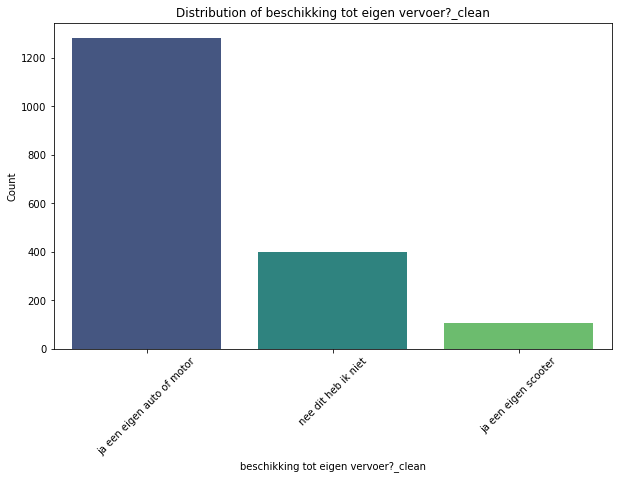

In [62]:
plot_categorical_distribution(df, column)

## Score 1

In [63]:
column = 'score 1'
answer_options = ["Laminaat leggen, lampen aansluiten op elektra, sleutelen aan scooter/auto",
                  "Gordijnen ophangen, batterij vervangen rookmelder, lampje verwisselen",
                  "Meer dan een half jaar ervaring in een technische functie (bijvoorbeeld monteur)"]
df[column] = df[column].apply(lambda x: x if x in answer_options else np.nan)

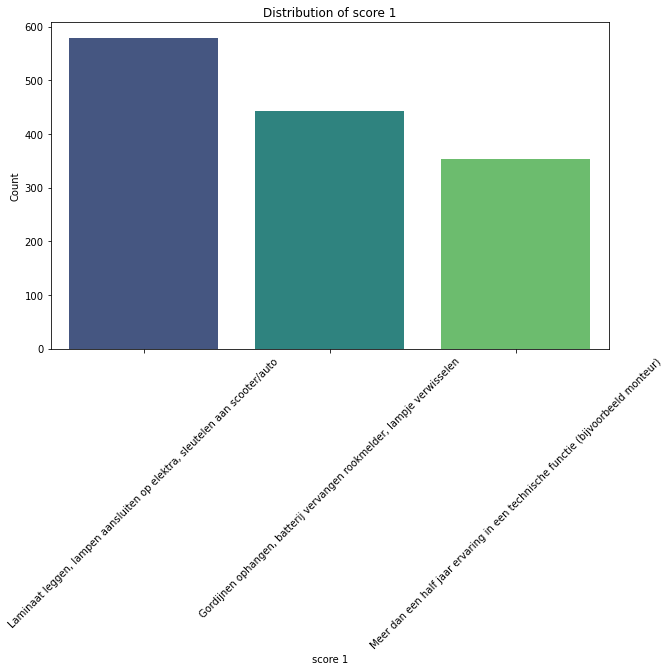

In [64]:
plot_categorical_distribution(df, column)

In [65]:
column = 'score 2'
df[column].value_counts()
#plot_categorical_distribution(df, column)

Houtwerk schilderen, leidingen verleggen, vervangen van kapotte stopcontacten       394
Meer dan een half jaar ervaring in een technische functie (bijvoorbeeld monteur)    341
Stofzuigerzak vervangen, verwijderen oude poster, dakgoot schoonmaken               244
Laminaat leggen, lampen aansluiten op elektra, sleutelen aan scooter/auto           215
Gordijnen ophangen, batterij vervangen rookmelder, lampje verwisselen               169
Name: score 2, dtype: int64

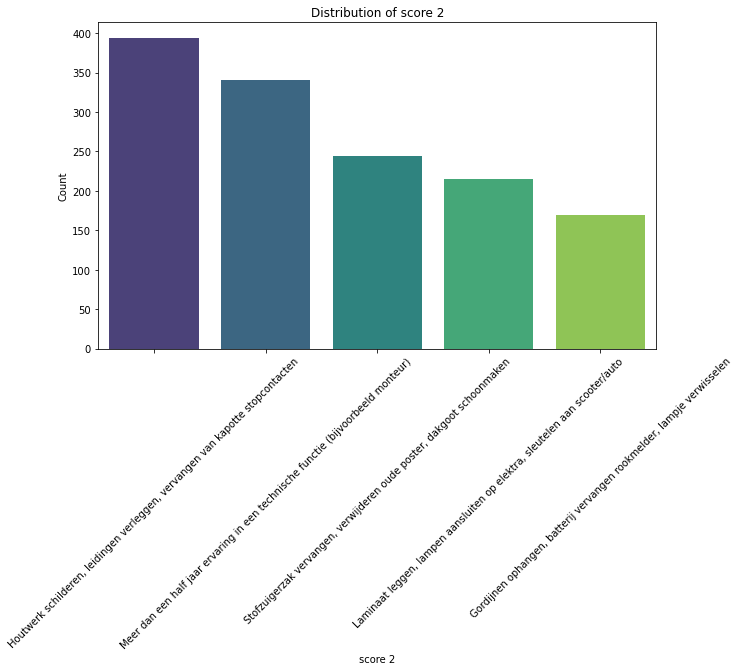

In [66]:
plot_categorical_distribution(df, column)

In [67]:
column = 'score 3'
df[column].value_counts()
#plot_categorical_distribution(df, column)

Kast in elkaar zetten, monteren nieuwe douchekop, deurbel installeren                     821
Meer dan een half jaar ervaring in een technische functie (bijvoorbeeld monteur)          322
Vervangen batterij afstandsbediening, schoonmaken afzuigkap, vastdraaien losse schroef    218
Name: score 3, dtype: int64

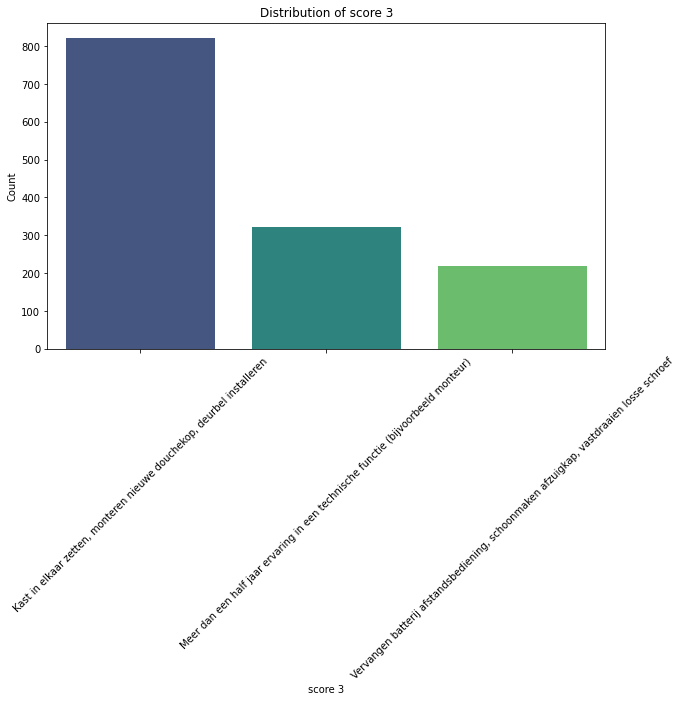

In [68]:
plot_categorical_distribution(df, column)

## Jaar ervaring

In [69]:
from datetime import datetime
import re 

def replace_fun(str_val):
     replace_dict = {
         ',':'.',
         ' ':'',
         'half':'0.5',
         'een': '1',
         'twee': '2',
         'drie': '3',
         'vier': '4',
         'vijf': '5',
         'zes': '6',
         'zeven': '7',
         'acht': '8',
         'negen': '9',
         'months':'maanden',
         'jaren':'jaar'
     }
     for orig, new in replace_dict.items():
         str_val = str_val.replace(orig, new)
         
     return str_val 

def extract_vals(str_val):
    try:
        #re.match(r'^-?\d+(?:\.\d+)$', str_val) is None: # geen float
        val = float(str_val)
        return val
    except:
        if str_val in ['niet','geen']:
            val = 0
            return val
        elif 'sinds' in str_val or 'vanaf' in str_val:
            matches = re.findall('(\d{4})',str_val)
            if len(matches) == 0:
                val = np.nan
            else:
                val = float(matches[0])
            return val
        if 'jaar' in str_val:
            pattern = r'(\d+\.\d+|\d+)\s*jaar'
        elif 'maand' in str_val:
            pattern = r'(\d+\.\d+|\d+)\s*maand'
        else:
            val = np.nan
            return val
        matches = re.findall(pattern, str_val)
        if len(matches) == 0:
            val = np.nan
        else:
            numbers = [float(match) for match in matches]
            val = numbers[0]
            if 'maand' in str_val:
                val = val/12
        
        return val

# Calculate the number of years worked
def calculate_years_worked(row):
    start_year = row['jaar_ervaring']
    end_date = row['cdate']
    
    if isinstance(end_date, datetime):
        piet= 0
    else:
        end_date = datetime(2024,1,1)
    # If start_year is a float, separate the year and the fraction
    year = int(start_year)
    fraction = start_year - year
    
    # Calculate the number of full years
    years_worked = end_date.year - year
    
    # Adjust for the fraction of the year
    if fraction > 0:
        # Calculate the exact date by adding the fraction as months
        start_date = datetime(year, 1, 1) + pd.DateOffset(months=int(fraction * 12))
        if end_date < start_date:
            years_worked -= 1
        elif end_date > start_date:
            extra_months = (end_date - start_date).days / 365.25
            years_worked += extra_months
    
    return years_worked



df.loc[df['Hoe lang in dienst/werkloos'] == 'Vijf een half jaar', 'Hoe lang in dienst/werkloos'] = '5.5jaar'

df['jaar_ervaring'] = df['Hoe lang in dienst/werkloos'].apply(lambda x: extract_vals(replace_fun(x.lower())) if isinstance(x, str) else x)
df.loc[df['jaar_ervaring'] > 1950, 'jaar_ervaring'] = df[df['jaar_ervaring'] > 1950].apply(calculate_years_worked,axis=1)

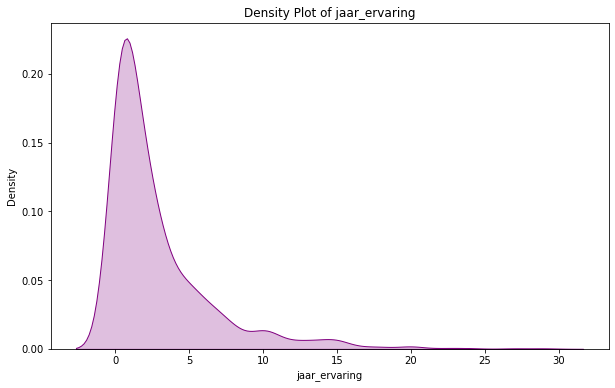

In [70]:
plot_density(df, 'jaar_ervaring')

In [71]:
df['jaar_ervaring'].sort_values()

9541    0.0
1516    0.0
448     0.0
456     0.0
457     0.0
       ... 
9768    NaN
9770    NaN
9818    NaN
9877    NaN
9878    NaN
Name: jaar_ervaring, Length: 4129, dtype: float64

In [72]:
df['jaar_ervaring'].sort_values()

9541    0.0
1516    0.0
448     0.0
456     0.0
457     0.0
       ... 
9768    NaN
9770    NaN
9818    NaN
9877    NaN
9878    NaN
Name: jaar_ervaring, Length: 4129, dtype: float64

## Convert postcode

In [73]:
# postcode > stad, provincie, randstad ja/nee
df['postcode_getal'] = df['postcode'].str[:4]
postal_code_data = pd.read_excel('data/postcodesNL.xlsx',converters={'Postcode':str})
df = df.merge(postal_code_data, left_on='postcode_getal', right_on='Postcode', how='left')

randstad_list = ['Amsterdam','Rotterdam','Den Haag','Utrecht','Almere','Haarlem','Amersfoort','Zaanstad','Haarlemmermeer','Zoetermeer','Leiden','Dordrecht','Alphen aan den Rijn','Westland','Alkmaar','Delft']
df['randstad'] = df['Gemeente'].isin(randstad_list)
df.loc[df['Gemeente'].isna(), 'randstad'] = np.nan
df.loc[df['postcode'] == 'Overig', 'randstad']=False

In [74]:
df.drop(['postcode'], axis=1, inplace=True)

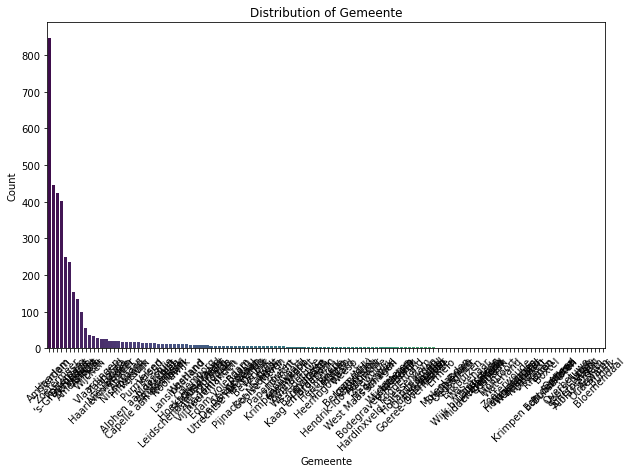

In [75]:
plot_categorical_distribution(df,'Gemeente')

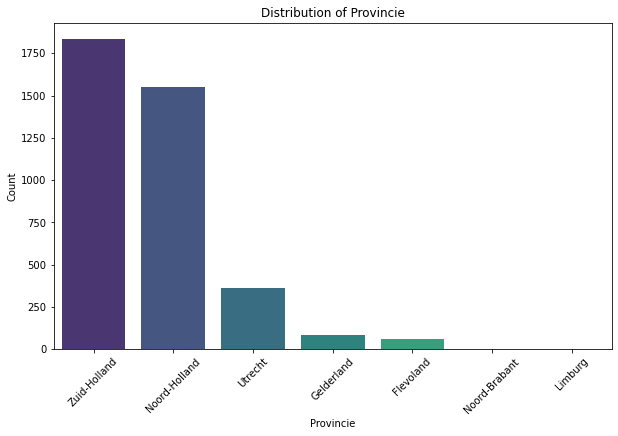

In [76]:
plot_categorical_distribution(df,'Provincie')

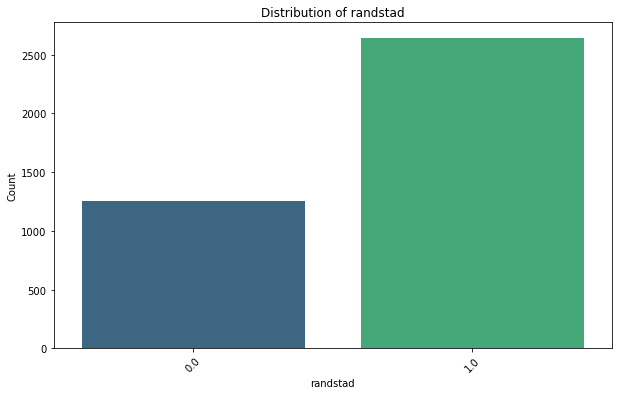

In [77]:
plot_categorical_distribution(df,'randstad')

## Werksituatie

In [78]:
df['Werksituatie'] = df['Werksituatie'].str.lower()
df['Werksituatie'].replace("werkloos","ik ben werkloos",inplace=True)
klus_answers = [ 'niks: 0 klussen',
       'weinig: 3 tot 4 klussen', 'regelmatig: 5 tot 8 klussen',
       'bij uitzondering: 1 tot 2 klussen', 'veel: meer dan 8 klussen']
df['Werksituatie'] = df['Werksituatie'].apply(lambda x: "ik ben zzp'er" if x in klus_answers else x)
answers = ['ik heb een tijdelijk contract (bepaalde tijd)', 'ik ben werkloos',
       'ik heb een vast contract', "ik ben zzp'er"]
df['Werksituatie'] = df['Werksituatie'].apply(lambda x: np.nan if x not in answers else x)


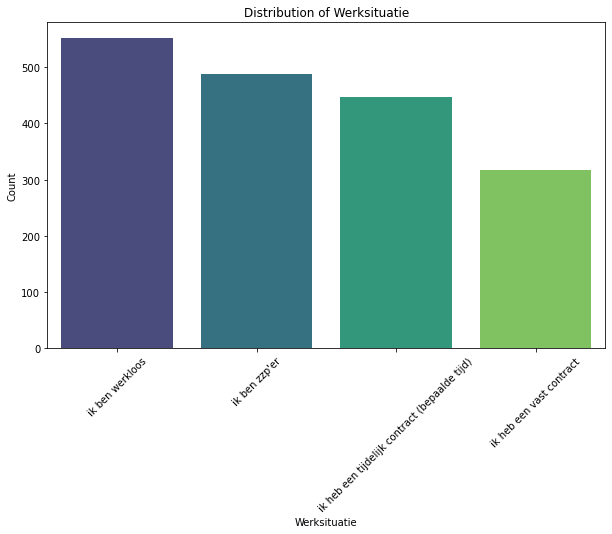

In [79]:
column = "Werksituatie"
plot_categorical_distribution(df, column)

In [80]:
df['Voorkeursbranche'] = df['Voorkeursbranche'].str.lower()

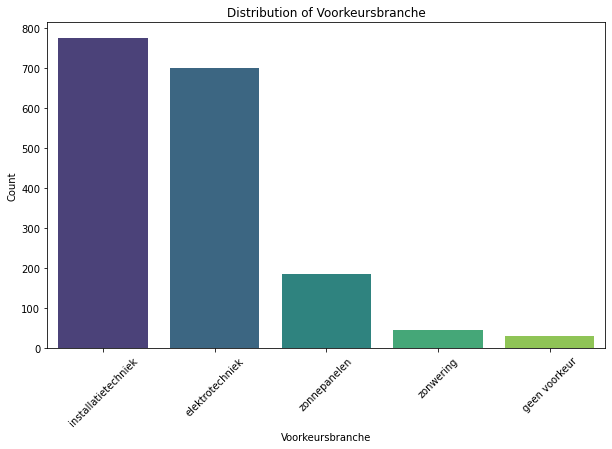

In [81]:
column = "Voorkeursbranche"
plot_categorical_distribution(df, column)

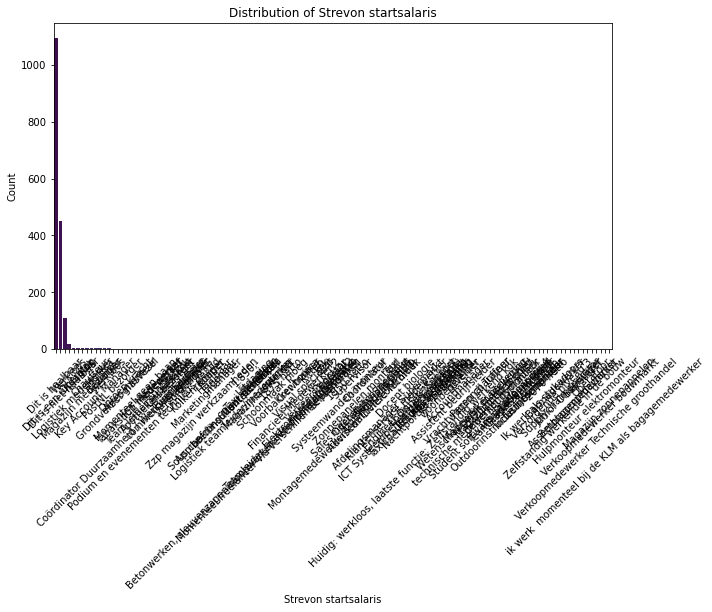

In [82]:
column = "Strevon startsalaris"
plot_categorical_distribution(df, column)

In [83]:
answers = ["Dit is haalbaar", "Dit is een uitdaging", "Dit is niet haalbaar"]
df[column] = df[column].apply(lambda x: np.nan if x not in answers else x)

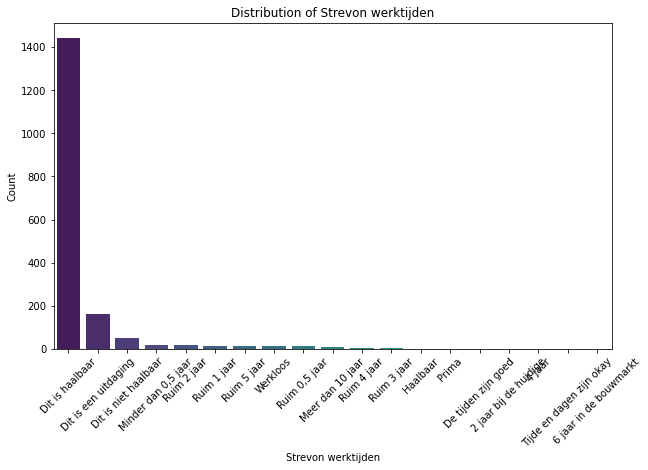

In [84]:
column = "Strevon werktijden"
plot_categorical_distribution(df, column)

In [85]:
answers = ["Dit is haalbaar", "Dit is een uitdaging", "Dit is niet haalbaar"]
df[column] = df[column].apply(lambda x: np.nan if x not in answers else x)

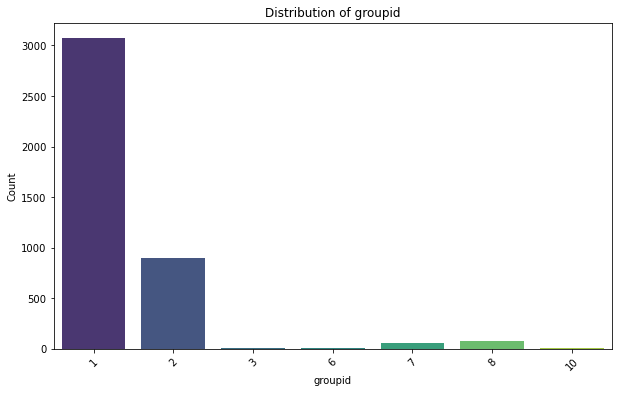

In [86]:
column = "groupid"
plot_categorical_distribution(df, column)

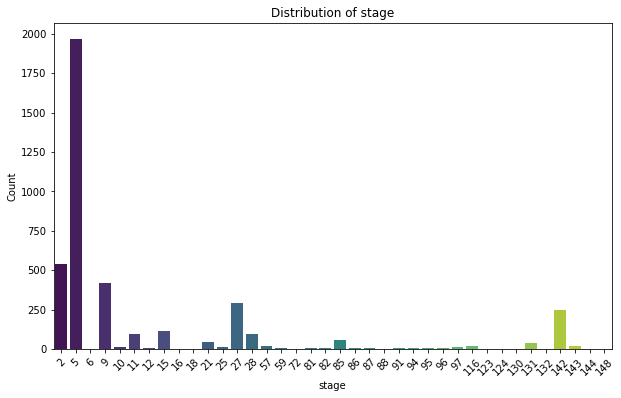

In [87]:
column = "stage"
plot_categorical_distribution(df, column)

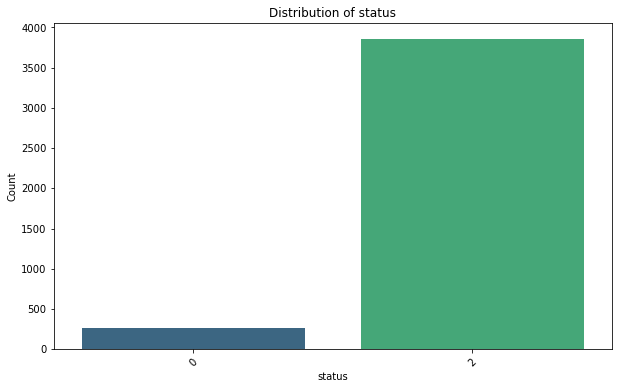

In [88]:
column = "status"
plot_categorical_distribution(df, column)

In [89]:
df.drop("Motivatie",axis=1,inplace=True)
df.drop("Huidig/Laatste functie",axis=1,inplace=True)
df.drop('Hoe lang in dienst/werkloos',axis=1,inplace=True)
df.drop('Meest trotste project',axis=1,inplace=True)

df.drop("uitkomstTelefonischContact",axis=1,inplace=True)
df.drop("Overname bedrag (W&S)",axis=1,inplace=True)
df.drop("Verloning marge stopper of W&S overname",axis=1,inplace=True)
df.drop("berekening",axis=1,inplace=True)

df.drop('postcode_getal',axis=1,inplace=True)
df.drop('Postcode',axis=1,inplace=True)


In [90]:
df['diff_days'] = (df['belafspraak'] - df['cdate']).dt.days
df[['cdate', 'belafspraak','diff_days']]

,cdate,belafspraak,diff_days
0,2024-05-29 14:53:57+00:00,2024-05-31 08:15:00+00:00,1.0
1,2024-05-29 10:25:32+00:00,2024-05-30 07:50:00+00:00,0.0
2,2024-05-29 09:31:01+00:00,NaT,NaN
3,2024-05-29 08:15:03+00:00,2024-05-30 07:40:00+00:00,0.0
4,2024-05-29 00:37:19+00:00,2024-05-30 08:40:00+00:00,1.0
...,...,...,...
4124,2021-08-29 12:24:47+00:00,2023-01-25 14:50:00+00:00,514.0
4125,2021-08-25 19:07:53+00:00,2022-07-05 14:30:00+00:00,313.0
4126,2021-08-18 16:06:37+00:00,2023-04-03 11:00:00+00:00,592.0
4127,2021-08-01 17:09:10+00:00,2022-10-04 12:40:00+00:00,428.0


In [91]:
date_cols = ['cdate','geboortedatum','belafspraak']
for col in date_cols:
    df[col] = pd.to_numeric(df[col])
    #df[col] = df[col].apply(lambda x: float(pd.Timestamp(x)) )

In [92]:
cols = df.columns.to_list()
cols.remove('starter')

In [93]:
# Identify columns with object data type (categorical variables)
categorical_columns = df.select_dtypes(include=['object']).columns

# Identify non-object type columns
non_categorical_columns = df.select_dtypes(exclude=['object']).columns

# Dummy code the categorical columns
df_dummies = pd.get_dummies(df[categorical_columns])

# Select non-categorical columns
df_non_categorical = df[non_categorical_columns]

# Concatenate the dummy coded variables with the non-categorical columns
df_final = pd.concat([df_non_categorical, df_dummies], axis=1)

In [94]:
# Calculate the sum of each column
column_sums = df_final.sum()

# Identify columns where the sum is greater than 10
columns_to_keep = column_sums[column_sums > 10].index

# Drop columns that don't sum to more than 10
df_final_filtered = df_final[columns_to_keep]

In [95]:
df_final_filtered.columns.to_list()

['recruitercode',
 'leeftijd',
 'geboortedatum',
 'groupid',
 'stage',
 'status',
 'starter',
 'jaar_ervaring',
 'diff_days',
 'utm_source_bing',
 'utm_source_facebook',
 'utm_source_fb-ig',
 'utm_source_google',
 'utm_source_indeed',
 'utm_source_nationaleberoepengids',
 'utm_source_other',
 'utm_source_strevon',
 'utm_source_tiktok',
 'utm_source_undefined',
 'utm_medium_cpc',
 'utm_medium_organic',
 'utm_medium_social',
 'utm_medium_undefined',
 'utm_campaign_algemeen_amsterdam',
 'utm_campaign_algemeen_rotterdam',
 'utm_campaign_awareness',
 'utm_campaign_branding',
 'utm_campaign_chat-popup',
 'utm_campaign_consideration',
 'utm_campaign_consideration_elektromonteur',
 'utm_campaign_elektromonteur',
 'utm_campaign_elektromonteur_amsterdam',
 'utm_campaign_elektromonteur_rotterdam',
 'utm_campaign_elektromonteur_utrecht',
 'utm_campaign_installatiemonteur',
 'utm_campaign_installatiemonteur-exp',
 'utm_campaign_installatiemonteur_amsterdam',
 'utm_campaign_installatiemonteur_denhaa

In [96]:
df_final_filtered.columns.to_list()

['recruitercode',
 'leeftijd',
 'geboortedatum',
 'groupid',
 'stage',
 'status',
 'starter',
 'jaar_ervaring',
 'diff_days',
 'utm_source_bing',
 'utm_source_facebook',
 'utm_source_fb-ig',
 'utm_source_google',
 'utm_source_indeed',
 'utm_source_nationaleberoepengids',
 'utm_source_other',
 'utm_source_strevon',
 'utm_source_tiktok',
 'utm_source_undefined',
 'utm_medium_cpc',
 'utm_medium_organic',
 'utm_medium_social',
 'utm_medium_undefined',
 'utm_campaign_algemeen_amsterdam',
 'utm_campaign_algemeen_rotterdam',
 'utm_campaign_awareness',
 'utm_campaign_branding',
 'utm_campaign_chat-popup',
 'utm_campaign_consideration',
 'utm_campaign_consideration_elektromonteur',
 'utm_campaign_elektromonteur',
 'utm_campaign_elektromonteur_amsterdam',
 'utm_campaign_elektromonteur_rotterdam',
 'utm_campaign_elektromonteur_utrecht',
 'utm_campaign_installatiemonteur',
 'utm_campaign_installatiemonteur-exp',
 'utm_campaign_installatiemonteur_amsterdam',
 'utm_campaign_installatiemonteur_denhaa

In [97]:
df_final_filtered.to_csv("data\df_final_filtered.csv",index=False)

In [98]:
len(df_final.columns)

737

In [99]:
len(df_final_filtered.columns)

309

In [100]:
df_final_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4129 entries, 0 to 4128
Columns: 309 entries, recruitercode to randstad_1.0
dtypes: float64(4), int64(5), uint8(300)
memory usage: 1.5 MB


In [101]:
# Calculate the correlation of each column with the target column 'starter'
correlations = df_final_filtered.corrwith(df_final_filtered['starter'])

# Create a list of correlations
correlation_list = correlations.drop('starter').tolist()  # Drop the target column itself from the list

# Create a list of column names
column_names = correlations.drop('starter').index.tolist()  # Drop the target column itself from the list

# Combine column names and correlations into a list of tuples
correlation_tuples = list(zip(column_names, correlation_list))
# Sort the list of tuples by the absolute value of the correlation coefficients in descending order
sorted_correlations = sorted(correlation_tuples, key=lambda x: abs(x[1]), reverse=True)

# Display the sorted list of correlations
print("\nSorted list of strongest correlations with 'starter':")
for column, corr in sorted_correlations:
    print(f"{column}: {corr}")


Sorted list of strongest correlations with 'starter':
groupid: 0.8492363853449229
status: -0.6963742419825005
stage: 0.323257240605522
uitkomstTelefonischDeal_Intake: 0.3205247471683795
Voorkeursbranche_installatietechniek: 0.10590391076579996
Voorkeursbranche_elektrotechniek: 0.10485428109789376
Voorkeursbranche_zonwering: 0.08518786642382899
uitkomstTelefonischDeal_Nam niet op: -0.07977177635922808
uitkomstTelefonischDeal_Niet geschikt - slechte indruk: -0.056077237701074
Ben je in het bezit van rijbewijs?_ja: -0.054652987714347644
geboortedatum: -0.05383696663087565
Plaats_Haarlem: 0.05381546270708507
Gemeente_Haarlem: 0.05381546270708507
utm_adgroup_no_loc_elektrotechniek_omscholing: 0.051710046921346946
uitkomstTelefonischDeal_Niet geschikt - spreekt slecht Nederlands: -0.047841755608735895
leeftijd: -0.046077903423737375
uitkomstTelefonischDeal_Niet geschikt - geen openstaande vacature: -0.04502965179196064
recruitercode: -0.044149084329262255
score 3_Vervangen batterij afstands

In [102]:
df_corr = pd.DataFrame(sorted_correlations,columns=['variable','correlation'])
df_corr

,variable,correlation
0,groupid,0.849236
1,status,-0.696374
2,stage,0.323257
3,uitkomstTelefonischDeal_Intake,0.320525
4,Voorkeursbranche_installatietechniek,0.105904
...,...,...
303,utm_campaign_location_rotterdam,0.000652
304,utm_adgroup_other,-0.000496
305,diff_days,0.000475
306,utm_adgroup_elektrotechniek_opleiding,-0.000331


In [103]:
df_corr.iloc[50:100].head(50)

,variable,correlation
50,Provincie_Gelderland,-0.026433
51,utm_campaign_no_loc_elektromonteur,0.026423
52,Gemeente_Amersfoort,-0.026142
53,Plaats_Amersfoort,-0.025824
54,Werksituatie_ik heb een tijdelijk contract (be...,-0.024876
55,Werksituatie_ik ben werkloos,-0.024649
56,utm_source_indeed,-0.024637
57,uitkomstTelefonischDeal_Geen interesse - heeft...,-0.024236
58,utm_campaign_location_amsterdam,0.024188
59,"score 1_Laminaat leggen, lampen aansluiten op ...",-0.023726


In [104]:
pd.DataFrame(df.describe(datetime_is_numeric=True))

,cdate,recruitercode,belafspraak,leeftijd,geboortedatum,groupid,stage,status,starter,jaar_ervaring,diff_days
count,4.129000e+03,3658.000000,4.129000e+03,3911.000000,4.129000e+03,4129.000000,4129.000000,4129.000000,4129.000000,1312.000000,3931.000000
mean,1.686814e+18,7.134773,1.165319e+18,31.490667,-4.903762e+18,1.455074,22.014774,1.870671,0.032938,2.873336,27.263801
std,1.901531e+16,2.232737,2.331884e+18,9.454906,4.943744e+18,1.253089,38.768113,0.491926,0.178495,3.713893,95.260101
min,1.627646e+18,1.000000,-9.223372e+18,17.000000,-9.223372e+18,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.671203e+18,7.000000,1.669627e+18,24.000000,-9.223372e+18,1.000000,5.000000,2.000000,0.000000,0.500000,1.000000
50%,1.689267e+18,7.000000,1.688974e+18,29.000000,-9.223372e+18,1.000000,5.000000,2.000000,0.000000,1.500000,2.000000
75%,1.702504e+18,9.000000,1.704703e+18,38.000000,7.318944e+17,2.000000,15.000000,2.000000,0.000000,4.000000,6.000000
max,1.716994e+18,12.000000,1.717574e+18,64.000000,1.684973e+18,10.000000,148.000000,2.000000,1.000000,29.000000,893.000000


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4129 entries, 0 to 4128
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cdate                                 4129 non-null   int64  
 1   recruitercode                         3658 non-null   float64
 2   belafspraak                           4129 non-null   int64  
 3   utm_source                            3956 non-null   object 
 4   utm_medium                            4049 non-null   object 
 5   utm_campaign                          2083 non-null   object 
 6   utm_adgroup                           1533 non-null   object 
 7   conversiepunt                         3888 non-null   object 
 8   pagina                                3411 non-null   object 
 9   uitkomstTelefonischDeal               3820 non-null   object 
 10  leeftijd                              3911 non-null   float64
 11  geboortedatum    

In [106]:
pd.DataFrame(df[['cdate','geboortedatum','belafspraak']].describe(datetime_is_numeric=True))

,cdate,geboortedatum,belafspraak
count,4.129000e+03,4.129000e+03,4.129000e+03
mean,1.686814e+18,-4.903762e+18,1.165319e+18
std,1.901531e+16,4.943744e+18,2.331884e+18
min,1.627646e+18,-9.223372e+18,-9.223372e+18
25%,1.671203e+18,-9.223372e+18,1.669627e+18
50%,1.689267e+18,-9.223372e+18,1.688974e+18
75%,1.702504e+18,7.318944e+17,1.704703e+18
max,1.716994e+18,1.684973e+18,1.717574e+18


In [107]:
df['geboortedatum'].iloc[0]

965433600000000000

In [108]:
date_cols = ['cdate','geboortedatum','belafspraak']
for col in date_cols:
    df[col] = pd.to_numeric(df[col])
    #df[col] = df[col].apply(lambda x: float(pd.Timestamp(x)) )

In [109]:
for col in df.columns.to_list():
    #print(f"{col}") 
    print(f"{len(df[df[col].isna()])}") 

0
471
0
173
80
2046
2596
241
718
309
218
0
2338
2339
2754
2766
2768
2392
2326
2475
2474
0
0
0
0
3568
2046
3586
2596
697
218
2339
2817
235
235
235
235
198
